Multi Armed Bandit
====

We formulate a simple bandit scheme involving 2 Machines and a Bernoulli Reward (0 or 1). Each Machine has a latent parameter governing its reward. There are a few possible goals:

1. Maximize Total Expected Rewards over N Trials
2. Find the "Best" Machine in as few trials as possible
3. Minimize "Regret" = Actual Reward - Reward of Best Action over N Trails

We designate the following:

$$R_1 = \text{Reward from Machine 1} \sim \text{Bernoulli}(\theta_1)$$
$$R_2 = \text{Reward from Machine 2} \sim \text{Bernoulli}(\theta_2)$$

$$\theta_1 \sim \text{Beta}(\alpha_1, \beta_1)$$
$$\theta_2 \sim \text{Beta}(\alpha_2, \beta_2)$$

In the beginning, we have no prior knowledge about either Machine, or more specifically, about the latent parameter governing each Machine. Therefore, we initially set $\alpha_1, \alpha_2, \beta_1, \beta_2 = 1$

Given our goals above, the main question becomes: **How do we choose which Machine to play in each Iteration?** We will refer to this question as our utility or acquisition function $U(\theta | X) = U(\alpha_1, \beta_1, \alpha_2, \beta_2 | X)$. The idea of this function is to weigh both exploitation of Machines we know give out a high reward, and exploration of other Machines that could possibly be better.

As we begin playing and gathering information, we continuously update our parameters of interest based on the outcome. Specifically:

1. $U(\alpha_1, \beta_1, \alpha_2, \beta_2) = j$ 
    * ( We choose Machine j )
2. $R_j = i$  
    * ( We play Machine j, and get Reward i )
3. If $R_j = 1$:
    $\alpha_j = \alpha_j + 1$  
4. If $R_j = 0$:
    $\beta_j = \beta_j + 1$  

The idea is to update our prior "belief" on the success of the individual Machines based on our empirical rewards. $\alpha$ represents "success", while $\beta$ represents "failure"

Before we discuss how to construct our Acquisition Function $U(\theta|X)$ which will help us decide which Machine to play at each iteration, we see two interesting points:

At time T = 1, we have no prior belief concerning any Machine. Thus, it will not matter which Machine we pick the first time around, though it will influence all subsequent choices.

At time T = N, we are at our final trial, and thus are only concerned for the Reward on this trial. As such, we will opt for a **Greedy** approach and pick the Machine with the highest Expected Reward - max($\frac{\alpha_1}{\alpha_1 + \beta_1}, \frac{\alpha_2}{\alpha_2 + \beta_2}$)

For times T = 2,...,N-1, we must choose the Machine based on the Expected Sum of Future Rewards, based on our framework above: $\mathbb{E}(\displaystyle\sum_{i=1}^{n} R_i)$

At time T = t, $\mathbb{E}(\displaystyle\sum_{i=t}^{n} R_i|M_{1:t-1}, R_{1:t-1})$ = $\mathbb{E}(\displaystyle\sum_{i=t+1}^{n} R_i|\theta)$ + $\mathbb{E}(R_t|\theta)$  
$M_{1:t}$ = Machines Chosen from times 1 to t  
$R_{1:t}$ = Rewards Given from times 1 to t

Given we perform N Trials, we construct our Algorithm in a Backwards Fashion:

1. For T = N:
    * For each node, we choose the **Greedy** option, that is, the one with the maximum expected return.

2. For T = N-1
    * Given that we know the most optimal choice for the last Trial, we select the Machine on this trial that will give us the maximum Expected **sum** of Rewards
    * $\mathbb{E}(R_{N-1} + R_{N})$, and we know $R_N$ from the previous iteration
    
3. For T = N-2,...,2:
    * We follow the similar intuition as above, choosing the most optimal choice for the maximum Expected sum of rewards, given the optimal choice for all subseqent trials already calculated
    * $\mathbb{E}(\displaystyle\sum_{i=T}^{n} R_i)$ = $\mathbb{E}(\displaystyle\sum_{i=t+1}^{n} R_i)$ + $\mathbb{E}(R_t)$
    
4. For T = 1:
    * From our above note, the first iteration does not matter, as we have no prior knowledge. We select any Machine at random.
    



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.gaussian_process import GaussianProcess
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

In [2]:
#Code to Generate Number of Nodes at Trial n#
def f(a, b, c, d, n):
    if n == 1:
        return pd.DataFrame(np.array([a,b,c,d])).T
    A = [a+1, b, c, d]
    B = [a, b+1, c, d]
    C = [a, b, c+1, d]
    D = [a, b, c, d+1]
    Nodes = pd.DataFrame(np.array([A, B, C, D]))
    for j in range(2,n):
        X = Nodes.shape[0]
        Nodes2 = pd.DataFrame()
        for i in range(X):
            A = Nodes.ix[i,:] + np.array([1,0,0,0])
            B = Nodes.ix[i,:] + np.array([0,1,0,0])
            C = Nodes.ix[i,:] + np.array([0,0,1,0])
            D = Nodes.ix[i,:] + np.array([0,0,0,1]) 
            Nodes2 = pd.concat([Nodes2, pd.DataFrame(np.array([A, B, C, D]))])
        Nodes = pd.DataFrame(pd.DataFrame.drop_duplicates(Nodes2)).reset_index(drop = True)
    return Nodes
    
def num_nodes(n):    
    for i in range(n):
        print("Trial",i+1,": ", f(1,1,1,1,i+1).shape[0])
            
num_nodes(10)

Trial 1 :  1
Trial 2 :  4
Trial 3 :  10
Trial 4 :  20
Trial 5 :  35
Trial 6 :  56
Trial 7 :  84
Trial 8 :  120
Trial 9 :  165
Trial 10 :  220


In [3]:
def minimize_func(p, E1, E2, E3, E4):
    return(-(p*(1 + E1) + p*(0 + E2) + (1-p)*(1 + E3) + (1-p)*(0 + E4)))

#Returns Previous Nodes, Finds best choice of machine based on future rewards
def Previous_Nodes_Func(a1, b1, a2, b2, N, Final_Nodes):
    Previous_Nodes = f(a1,b1,a2,b2,N)
    Previous_Nodes.insert(4, 4, 0)
    Previous_Nodes.insert(5, 5, 0)
    for j in range(Previous_Nodes.shape[0]):
        Node = Previous_Nodes.ix[j,0:3]
        A = Node + np.array([1,0,0,0])
        B = Node + np.array([0,1,0,0])
        C = Node + np.array([0,0,1,0])
        D = Node + np.array([0,0,0,1])
            
        E1 = Final_Nodes.values[np.alltrue(Final_Nodes.ix[:,0:3] == A, axis = 1),4]
        E2 = Final_Nodes.values[np.alltrue(Final_Nodes.ix[:,0:3] == B, axis = 1),4]
        E3 = Final_Nodes.values[np.alltrue(Final_Nodes.ix[:,0:3] == C, axis = 1),4]
        E4 = Final_Nodes.values[np.alltrue(Final_Nodes.ix[:,0:3] == D, axis = 1),4]
            
        choice = np.round(minimize_scalar(minimize_func, method = 'bounded', bounds = [0,1], args = (E1, E2, E3, E4)).x)
        Previous_Nodes.ix[j,4] = -minimize_func(choice, E1, E2, E3, E4)
        Previous_Nodes.ix[j,5] = choice
        
    return(Previous_Nodes)

#Input:
#a1,b1,a2,b2 - Prior Parameters of Machine at CURRENT TRIAL
#N - Number of Trials Remaining
#
#Output:
#Choice of Machine at Current Iteration & Expected Sum of Rewards
def Bernoulli_Bandit(a1, b1, a2, b2, N):   
    
    #Create Data Frame of Final Nodes
    Final_Nodes = f(a1,b1,a2,b2,N)
    
    #Create Empty Column to Hold Expected#
    Final_Nodes.insert(4, 4, 0)
    
    #Add Column of Final Expected Result
    for i in range(Final_Nodes.shape[0]):
        E_1 = Final_Nodes.ix[i,0]/(Final_Nodes.ix[i,0]+Final_Nodes.ix[i,1])
        E_2 = Final_Nodes.ix[i,2]/(Final_Nodes.ix[i,2]+Final_Nodes.ix[i,3])
        Final_Nodes.ix[i,4] = max(E_1, E_2)

    Previous_Node = Final_Nodes
    
    for j in range(1,N)[::-1]:
        Previous_Node = Previous_Nodes_Func(a1, b1, a2, b2, j, Previous_Node)
    
    return(Previous_Node)

In [82]:
Bernoulli_Bandit(11, 11, 10, 10, 3)

,0,1,2,3,4,5
0,11,11,10,10,5.047619,1


In [701]:
##Gaussian Process Code##


# Simulate data
%matplotlib inline
import numpy as np
from sklearn import gaussian_process
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

np.random.seed(146)
# m = 10, 20, 100
m=10
#y = np.array([0.05,0.1,0.3,0.2,0.5])
y = np.random.uniform(0.05,0.95,m)
# Here specified the true reward of each machine
def f(x):
    if type(x).__module__ == np.__name__:
        x = x.T.astype(int)
    if isinstance(x,list):
        x = np.asarray(x,int)
    return y[x-1]


In [472]:
#Inputs are:

#1. Your initial choice
#2. Your true value(function)
#3. Number of machines
#4. Tuning parameter

def armedbandit(choice,f,m,eps):
    i = 1
    x = np.atleast_2d(np.linspace(1, m, m)).T
    choice2 = list(choice)
    # Randomly set initial values to be appended
    point_append_after = 2
    point_append_before = 1
    maxi = max(f(x)[0])
    regret = (maxi - f(choice)).tolist()
    
    # When the points are not changing, stop and return
    while point_append_after != point_append_before:
        # The largest reward 
        mu_plus = f(choice)[np.argmax(f(choice))]
        # Fit Gaussian Process
        X = np.atleast_2d(choice).T
        y = f(X).ravel()
        gp = gaussian_process.GaussianProcess(theta0=1e-1, thetaL = 1e-4, thetaU = 1e-1)
        gp.fit(X, y)
        y_pred, sigma2_pred = gp.predict(x, eval_MSE=True)
        sigma = np.sqrt(sigma2_pred)

        fig = plt.figure(figsize=(10, 5))
        plt.scatter(x, f(x).T, color='darkred', label='True reward')
        plt.plot(x, y_pred, 'b-', label='Prediction',linestyle='--')
        plt.plot(X, y, 'r.', markersize=10, label='Observations')
        plt.fill(np.concatenate([x, x[::-1]]),
                np.concatenate([y_pred - 3 * sigma,
                               (y_pred + 3 * sigma)[::-1]]),
                alpha=.5, fc='b', ec='None', label='95% CI')
        plt.legend(loc='upper left')
        plt.title("Approximating true function with more data",size=16)
        plt.ylabel("Expected reward")
        plt.xlabel("machines")
        plt.xlim(-5,m+1)
        plt.savefig('testplot' + str(i) +'.png')
        i +=1
        plt.close(fig)
        point_append_before = point_append_after
        
        #Choosing point_append_after
        seq = norm.cdf((y_pred - mu_plus-eps)/sigma)
        #axis_x = range(1,m+1)
        #plt.plot(axis_x,seq)
        point_append_after = np.argmax(seq)+1
        if point_append_after == point_append_before:
            break
        choice2.append(point_append_after)
        
        expected_reward = f([point_append_after])
        regret.append((maxi - expected_reward)[0])
        
        if point_append_after in choice:
            continue
        choice.append(point_append_after)

    return(choice2,regret)

In [702]:
m = 10
x = np.atleast_2d(np.linspace(1, m, m)).T
choice = [2,3]
path1,regrets1 = armedbandit(choice,f,m,0.01)
path2,regrets2 = armedbandit(choice,f,m,0.1)
path3,regrets3 = armedbandit(choice,f,m,1)
Best_reward_10 = np.array([max(f(x)[0]),max(f(path1)),max(f(path2)),max(f(path3))])

In [703]:
Best_reward_10

array([ 0.90031643,  0.90031643,  0.90031643,  0.90031643])

In [693]:
m = 20
x = np.atleast_2d(np.linspace(1, m, m)).T
choice = [2,3]
path1,regrets1 = armedbandit(choice,f,m,0.01)
path2,regrets2 = armedbandit(choice,f,m,0.1)
path3,regrets3 = armedbandit(choice,f,m,1)
Best_reward_20 = np.array([max(f(x)[0]),max(f(path1)),max(f(path2)),max(f(path3))])

In [694]:
Best_reward_20

array([ 0.94003156,  0.90031643,  0.90031643,  0.94003156])

In [699]:
m = 100
x = np.atleast_2d(np.linspace(1, m, m)).T
choice = [2,3]
path1,regrets1 = armedbandit(choice,f,m,0.01)
path2,regrets2 = armedbandit(choice,f,m,0.1)
path3,regrets3 = armedbandit(choice,f,m,1)
Best_reward_100 = np.array([max(f(x)[0]),max(f(path1)),max(f(path2)),max(f(path3))])

In [700]:
Best_reward_100

array([ 0.94410245,  0.78680679,  0.86021828,  0.86021828])

In [704]:
tune_reward = np.vstack((Best_reward_10,Best_reward_20,Best_reward_100))
tune_reward

array([[ 0.90031643,  0.90031643,  0.90031643,  0.90031643],
       [ 0.94003156,  0.90031643,  0.90031643,  0.94003156],
       [ 0.94410245,  0.78680679,  0.86021828,  0.86021828]])

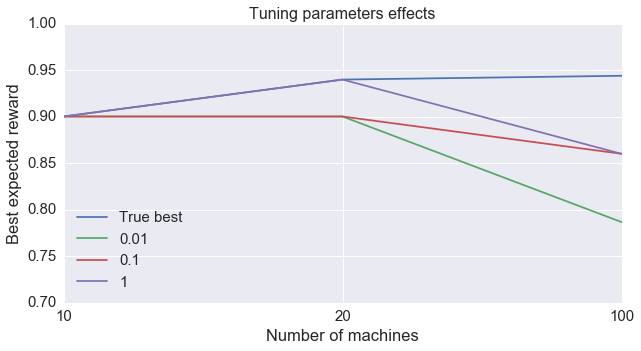

In [716]:
plt.figure(figsize=(10, 5))
x = [0,1,2]
my_xticks = ["10", "20", "100"]
plt.xticks(x, my_xticks)

plt.plot(x, tune_reward[:,0],label='True best')
plt.plot(x, tune_reward[:,1],label='0.01')
plt.plot(x, tune_reward[:,2],label='0.1')
plt.plot(x, tune_reward[:,3],label='1')
plt.legend(loc='lower left')
plt.title("Tuning parameters effects",size=16)
plt.ylabel("Best expected reward")
plt.xlabel("Number of machines")
plt.ylim(0.7,1)
pass

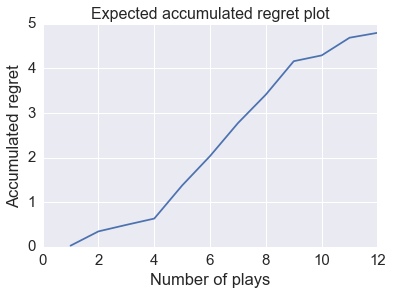

In [407]:
plt.plot(np.arange(1, len(regrets1)+1),np.cumsum(regrets1))
plt.title("Expected accumulated regret plot",size=16)
plt.ylabel("Accumulated regret")
plt.xlabel("Number of plays")
pass